### Collaborative Filtering Movie Recommender 

Data Used:
* tmdb_5k
* the_movie_datasets
* movielens20m

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns 
import matplotlib.pyplot as plt # visualization tool
import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import sklearn

from surprise import Reader, Dataset, SVD, model_selection
from surprise.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
saving=False

print(os.listdir("Datasets/"))

['ml-20m', 'ml-20m.zip', 'netflix-prize-data.zip', 'the-movies-dataset', 'the-movies-dataset.zip', 'tmdb-movie-metadata', 'tmdb-movie-metadata.zip']


In [2]:
# tmdb_5k
tmdb_5000_movies=pd.read_csv("Datasets/tmdb-movie-metadata/tmdb_5000_movies.csv")
tmdb_5000_credits=pd.read_csv("Datasets/tmdb-movie-metadata/tmdb_5000_credits.csv")

# movie_datasets
data_movie = pd.read_csv('Datasets/the-movies-dataset/movies_metadata.csv')
data_rating_small = pd.read_csv('Datasets/the-movies-dataset/ratings_small.csv')
data_links_small = pd.read_csv('Datasets/the-movies-dataset/links_small.csv')

# movielens-20m
movielens_rating=pd.read_csv("Datasets/ml-20m/ratings.csv")
movielens_link=pd.read_csv("Datasets/ml-20m/links.csv")
movielens_movie=pd.read_csv("Datasets/ml-20m/movies.csv")
movielens_score=pd.read_csv("Datasets/ml-20m/genome-scores.csv")
movielens_tag=pd.read_csv("Datasets/ml-20m/genome-tags.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
tmdb_5000_credits.columns = ['id', 'title', 'cast', 'crew']
tmdb_5000 = tmdb_5000_movies.copy(deep=True)
tmdb_5000 = tmdb_5000.merge(tmdb_5000_credits, on=['id', 'title'])

In [4]:
movielens_dict={v:k for k,v in movielens_link.movieId.to_dict().items()}
movielens_rating.movieId=movielens_rating.movieId.apply(movielens_dict.get)
movielens_rating.userId-=1
movielens_score.movieId=movielens_score.movieId.apply(movielens_dict.get)
movielens_score.tagId-=1
movielens_tag.tagId-=1

In [5]:
tmdb_5000.dropna(subset=["release_date"], inplace=True)
tmdb_5000.replace(0, np.nan, inplace=True)

### Exploratory Data Analysis (EDA)
what should i do ? huh ?

In [6]:
# helper functions to deal with multi-hot features
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

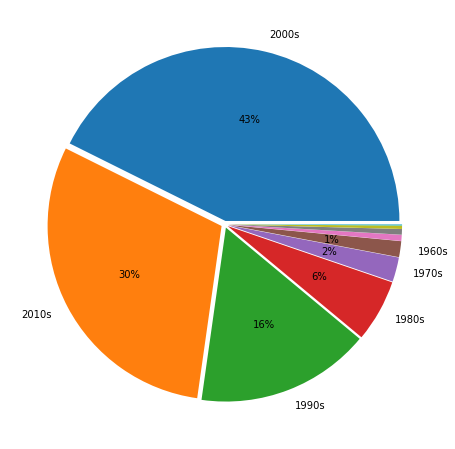

In [7]:
# numbers of movies released in each decade
def count_pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df,filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)
    
count_decade_pie(tmdb_5000,filename="pie_decade.png")

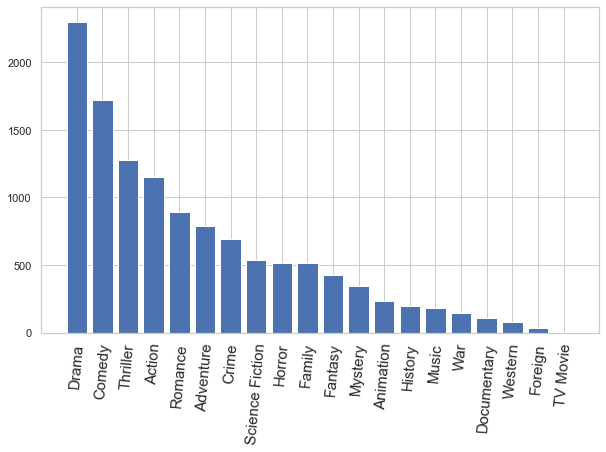

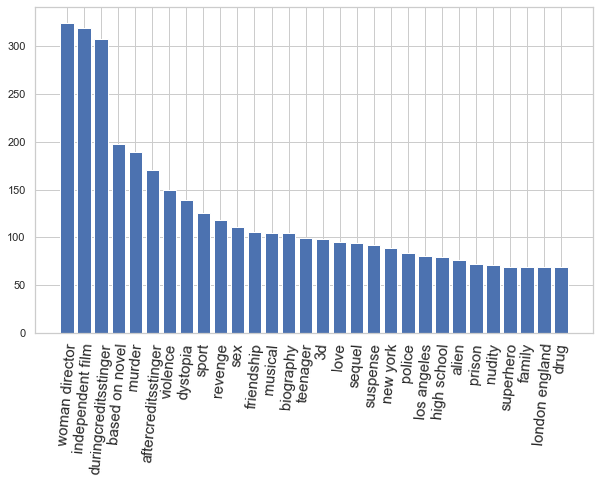

In [8]:
# numbers of movies of different genres and keywords
def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
#     plt.pie(count.values(),labels=count.keys())
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()

multi_bar(tmdb_5000.genres,filename="bar_genres.png")
multi_bar(tmdb_5000.keywords,filename="bar_keywords.png")

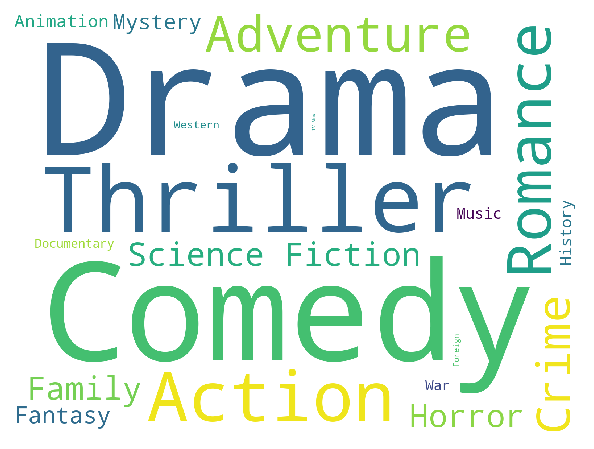

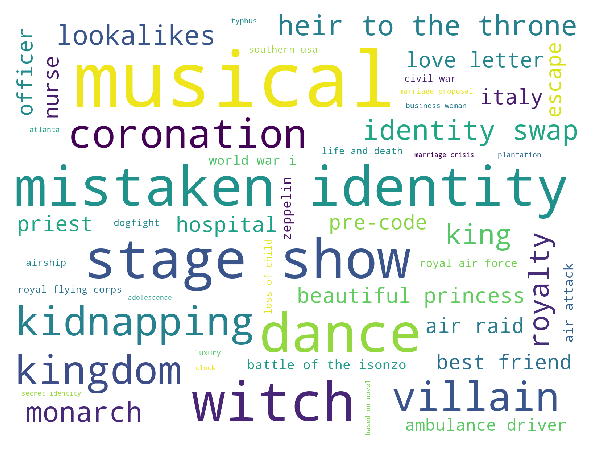

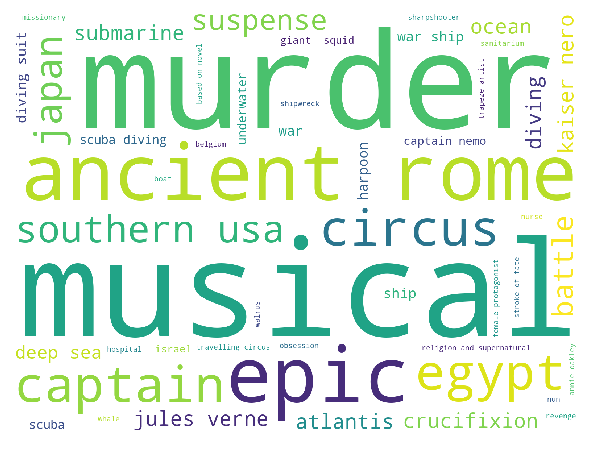

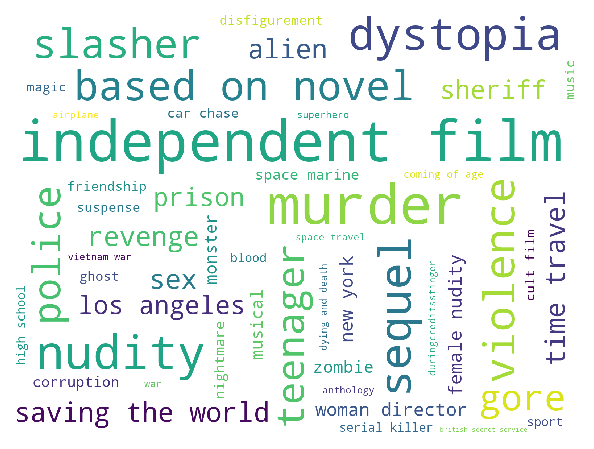

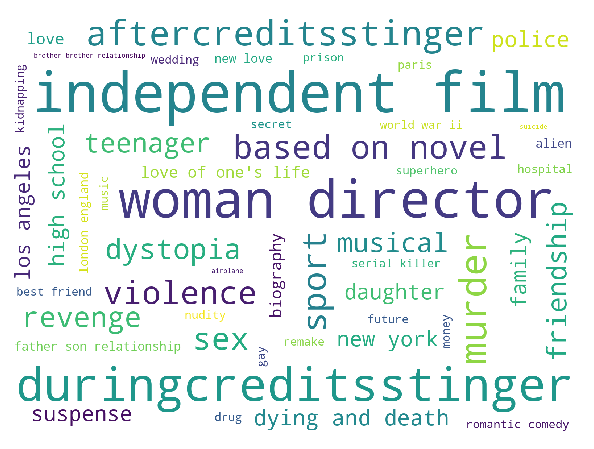

In [9]:
# wordcloud of genres and keywords
def multi_wordcloud(series,filename):
    w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count=multi_count(series,"name")
    w.generate_from_frequencies(count)
    if saving:w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()

multi_wordcloud(tmdb_5000.genres,filename="wordcloud_genres.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1930],filename="wordcloud_keywords_1930.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1950],filename="wordcloud_keywords_1950.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1980],filename="wordcloud_keywords_1980.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==2000],filename="wordcloud_keywords_2000.png")

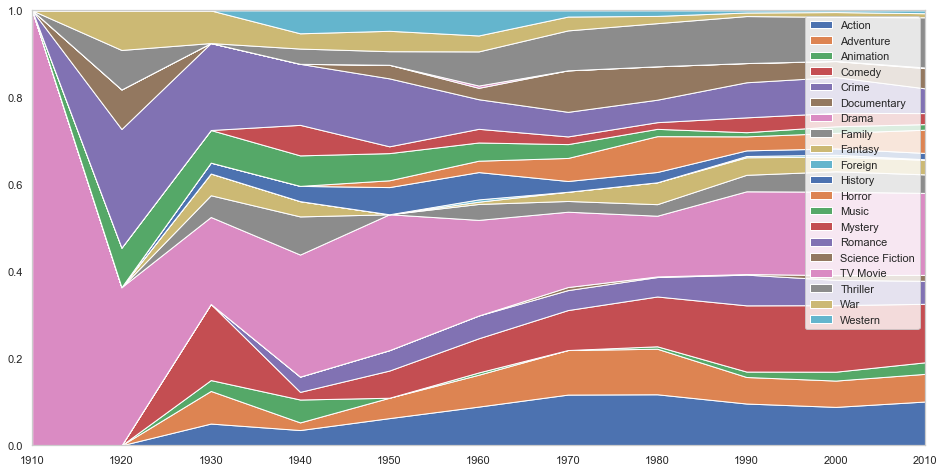

In [10]:
# change of percentage of movies of each genres released in each decade
def multi_stackplot_10year(df,value,filename):
    sns.set(style="whitegrid")
    df=df[["release_date",value]].dropna()
    df.release_date=df.release_date.apply(lambda x:int(x[:4])//10*10)
    df=df.sort_values("release_date")
    years=pd.Series(range(df["release_date"].min(),df["release_date"].max()+1,10),name="year")
    counts=[]
    groups=[]
    for (name,col) in multi_groupby(df,"genres","name"):
        groups.append(name)
        counts.append(pd.merge(years.to_frame(),col.groupby("release_date").size().rename("count").to_frame(),
                               how="left",left_on="year",right_on="release_date").fillna(0).astype(int)["count"])
    counts=np.array(counts)
    counts=counts.transpose(0,1)
    counts=counts/counts.sum(0)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(years,counts,labels=groups)
    plt.xticks(years)
    plt.xlim(years.iloc[0],years.iloc[-1])
    plt.ylim(0,1)
    plt.legend()
    if saving:plt.savefig(filename,dpi=200)
    plt.show()

multi_stackplot_10year(tmdb_5000,"genres",filename="stackplot_genres.png")

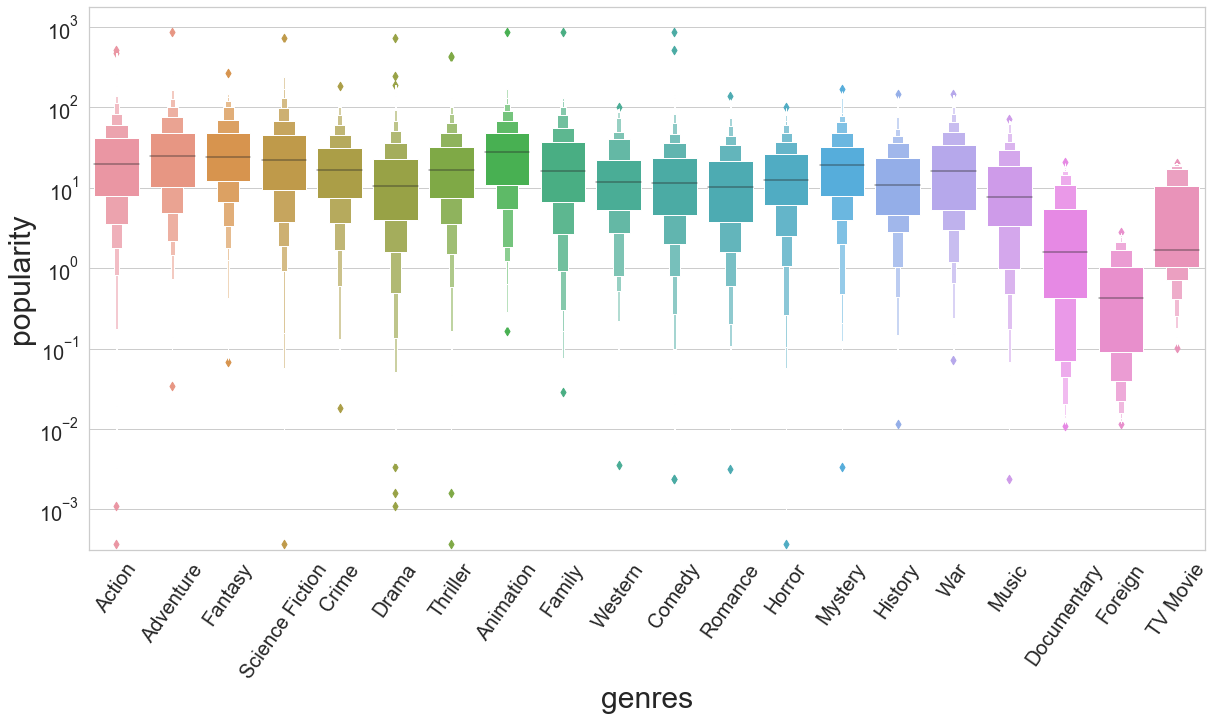

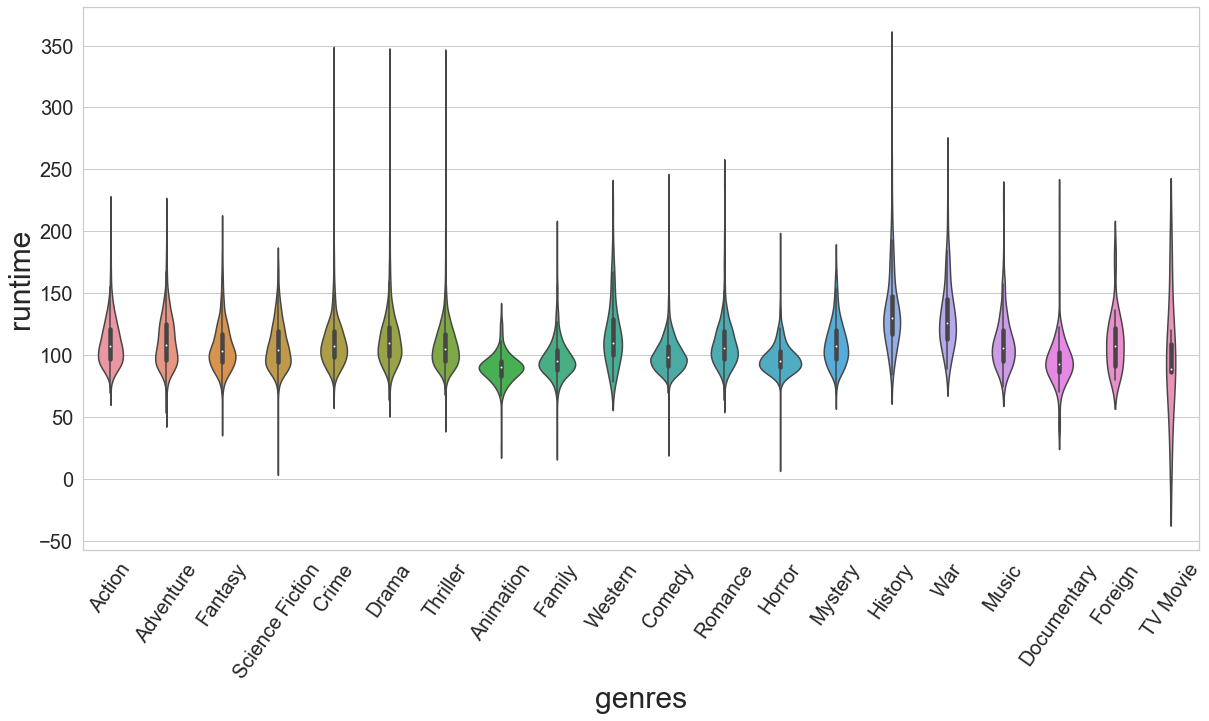

In [11]:
# distribution of popularity and runtime groupby genres
def plotby_box(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
def plotby_violin(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.violinplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_box(tmdb_5000,"genres","popularity",yscale="log",filename="genres_popularity.png")
plotby_violin(tmdb_5000,"genres","runtime",yscale="linear",filename="genres_runtime.png")

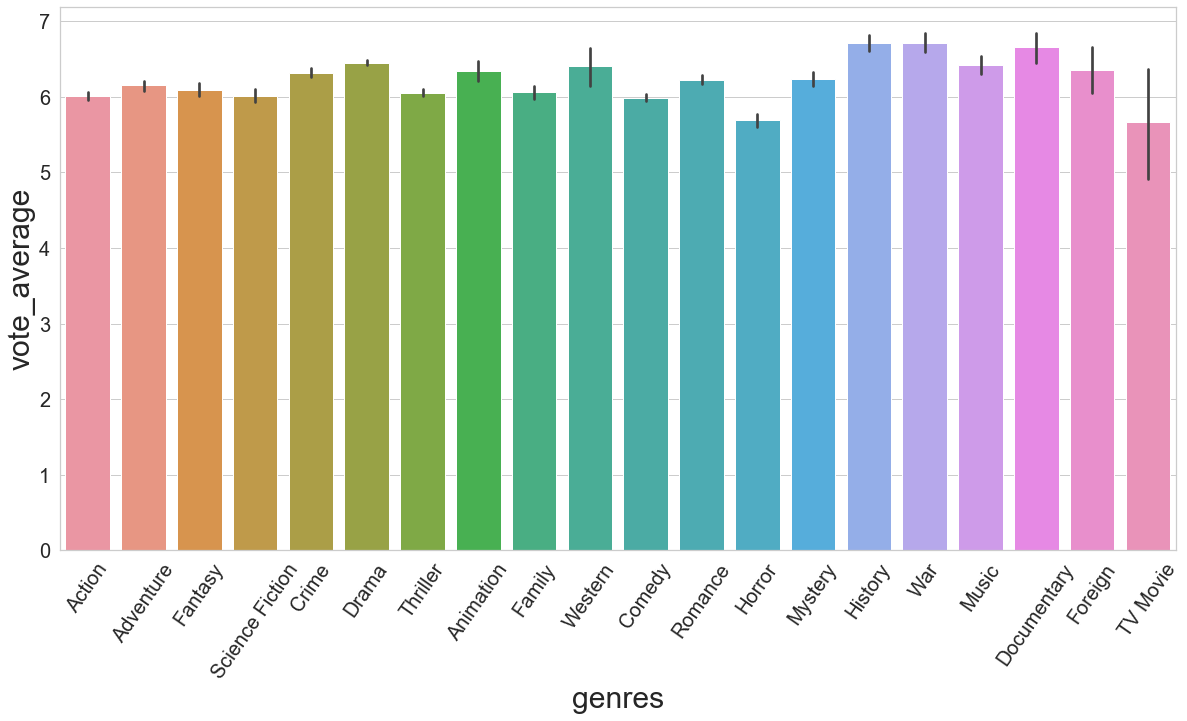

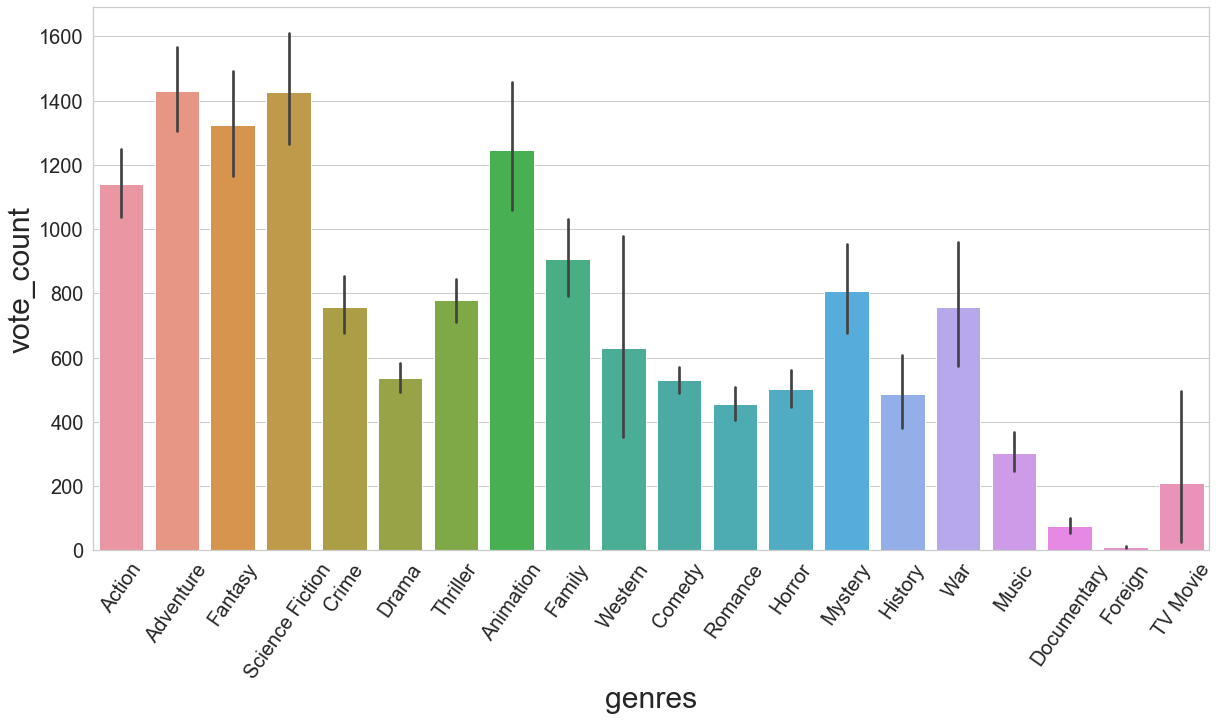

In [12]:
# average vote of each genres' movies
def plotby_bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.barplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_bar(tmdb_5000,"genres","vote_average",filename="genres_vote_average.png")
plotby_bar(tmdb_5000,"genres","vote_count",filename="genres_vote_count.png")

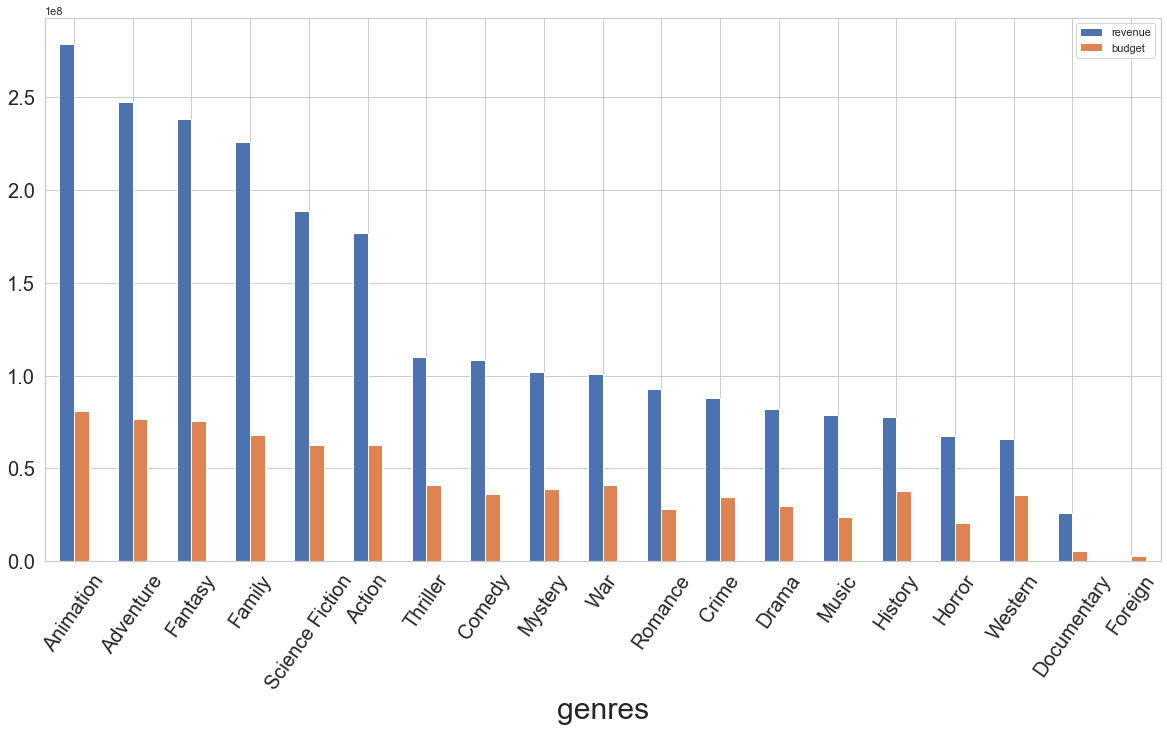

In [13]:
# average budget and revenue of each genres' movies
def plotby_2bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

plotby_2bar(tmdb_5000,"genres",["revenue","budget"],filename="genres_budget_revenue.png")

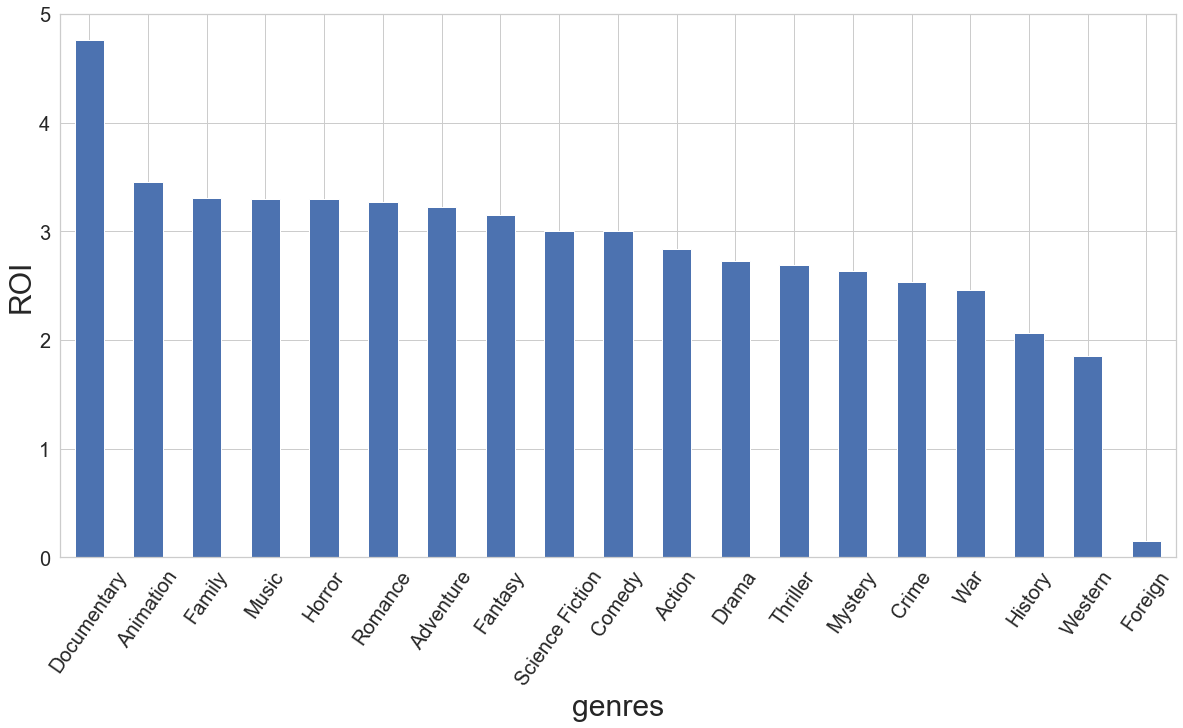

In [14]:
# return on investment of each genres' movies
def plotby_portion(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
#     sns.barplot(data=multi_groupby(df,x,"name")[y].mean().transpose())
    group=multi_groupby(df.dropna(subset=y),x,"name")
    (group[y[0]].mean()/group[y[1]].mean()).sort_values(ascending=False).plot(kind="bar")
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel("ROI",fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_portion(tmdb_5000,"genres",["revenue","budget"],filename="genres_ROI.png")

# Singular Value Decomposition

One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

In [15]:
# SVD
reader = Reader()
ratings = pd.read_csv('Datasets/the-movies-dataset/ratings_small.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [16]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# trainset = data.build_full_trainset()
# model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8967  0.8918  0.8934  0.9009  0.8954  0.8956  0.0031  
MAE (testset)     0.6890  0.6881  0.6867  0.6936  0.6892  0.6893  0.0023  
Fit time          4.82    4.96    4.97    5.02    4.95    4.94    0.07    
Test time         0.14    0.14    0.20    0.14    0.14    0.15    0.02    


{'test_rmse': array([0.89671573, 0.89176692, 0.89344113, 0.90090705, 0.89538125]),
 'test_mae': array([0.68898981, 0.68808335, 0.68668545, 0.6935975 , 0.68919711]),
 'fit_time': (4.822957515716553,
  4.956398963928223,
  4.968982696533203,
  5.024689674377441,
  4.950430631637573),
 'test_time': (0.13946175575256348,
  0.1429741382598877,
  0.19514799118041992,
  0.13794612884521484,
  0.13745880126953125)}

In [17]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [18]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.5797819437397096, details={'was_impossible': False})

# Recommendation

Item Based Collaborative Filtering using sparse matrix

In [19]:
# define transformers
class SparseMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,row=None,col=None,value=None,shape=None):
        self.row=row
        self.col=col
        self.value=value
        self.shape=shape
    
    def fit(self,X,y=None):
        self.shape=(X[self.row].max()+1,X[self.col].max()+1)
        return self
    
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            return sparse.csr_matrix(sparse.coo_matrix((X[self.value],(X[self.row],X[self.col])),self.shape))
        else:
            return sparse.csr_matrix(sparse.coo_matrix((X[:,2],(X[:,0],X[:,1])),self.shape))
    
user_movie_transformer=SparseMatrixTransformer(row="userId",col="movieId",value="rating").fit(movielens_rating)
movie_tag_transformer=SparseMatrixTransformer(row="movieId",col="tagId",value="relevance",shape=(user_movie_transformer.shape[1],movielens_tag.tagId.max()+1))

In [62]:
# base class for recommendation system
class RecommenderMixin(BaseEstimator,TransformerMixin):
    def __init__(self,n_rec=10):
        self.n_rec=n_rec
    
    def evaluate(self,X_train,X_valid,silent=False):
        n_users,n_items=X_train.shape
        X=(X_train+X_valid).T
        item_rating=np.array([row.data.mean() if row.nnz else 0 for row in X])
        item_rating[np.isnan(item_rating)]
        mean_rating=X.data.mean()
        if not silent:print("predicting...")
        recommend=self.predict(X_train)
        if not silent:print("evaluating...")
        intersect=np.asarray(X_valid[np.arange(n_users).repeat(self.n_rec),recommend.flatten()].reshape(n_users,-1))
        hit=(intersect!=0).sum()
        precision=hit/recommend.size
        recall=hit/X_valid.nnz
        coverage=np.unique(recommend).size/n_items
        hit_rating=(intersect[intersect!=0]).mean()
        indices=recommend[(intersect!=0)]
        recom_rating=np.average(item_rating[indices])
        print("accuracy=%.4f"%precision)
        print("recall=%.4f"%recall)
        print("cover=%.4f"%coverage)
        print("user's vote to the hit movies=%.4f"%(hit_rating))
        print("average vote to the hit movies=%.4f"%(recom_rating))
        print("average vote to all movies=%.4f"%(mean_rating))
        
    def fit_predict(self,X,y=None):
        return self.fit(X,y).predict(X)

In [21]:
# item based colaborative filtering
# calculating the similarity between movies based on users' vote to the movies
class ItemBasedCF(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=20,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        if not silent:print("calculating the similar matrix...")
        n_users,n_items=X.shape
        user_movie=X.copy()
        user_movie.data-=self.baseline
        norms=sparse.linalg.norm(user_movie,axis=0)
        norms[norms==0]=1
        user_movie*=sparse.diags(1/norms)
        movie_sim_matrix=user_movie.T*user_movie
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# itemCF=ItemBasedCF(file_name="ItemBasedCF.npz")

In [22]:
# fitting item based colaborative filtering
itemCF=ItemBasedCF()
%time itemCF.fit(user_movie_transformer.transform(movielens_rating))
if saving:itemCF.save("ItemBasedCF.npz")

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
Wall time: 53.5 s


In [56]:
movielens_movie.iloc[17506]

movieId                                        88140
title      Captain America: The First Avenger (2011)
genres          Action|Adventure|Sci-Fi|Thriller|War
Name: 17506, dtype: object

In [23]:
# example of the most similar movies to a specified movie
def movie_similar(rs,movie):
    index=rs.similar_matrix[movie].indices
    return pd.merge(movielens_movie.iloc[index].reset_index(drop=True),pd.DataFrame({"similar":rs.similar_matrix[movie,index].toarray().flatten()}),left_index=True,right_index=True).sort_values("similar",ascending=False).reset_index(drop=True)
    
movie_similar(itemCF,17506)

,movieId,title,genres,similar
0,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,1.000000
1,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,0.482128
2,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.413647
3,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.401208
4,87232,X-Men: First Class (2011),Action|Adventure|Sci-Fi|Thriller|War,0.390539
5,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,0.354732
6,95510,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.331462
7,91542,Sherlock Holmes: A Game of Shadows (2011),Action|Adventure|Comedy|Crime|Mystery|Thriller,0.323050
8,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,0.321387
9,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,0.298413


In [43]:
movielens_rating[movielens_rating.userId == 5]

,userId,movieId,rating,timestamp
517,5,0,5.0,858275452
518,5,2,3.0,858275558
519,5,6,5.0,858275558
520,5,16,5.0,858275452
521,5,51,5.0,858275658
522,5,61,5.0,858275452
523,5,133,3.0,858275783
524,5,138,4.0,858275917
525,5,139,5.0,858275452
526,5,257,4.0,858275658


In [24]:
# see the already watched movies of a specified movie
def user_watched(user):
    watched_movies=movielens_rating[movielens_rating.userId==user]
    return pd.DataFrame({"title":movielens_movie.title.iloc[watched_movies.movieId],"genres":movielens_movie.genres.iloc[watched_movies.movieId],"rating":watched_movies.rating.values})

user_watched(5)

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0
2,Grumpier Old Men (1995),Comedy|Romance,3.0
6,Sabrina (1995),Comedy|Romance,5.0
16,Sense and Sensibility (1995),Drama|Romance,5.0
51,Mighty Aphrodite (1995),Comedy|Drama|Romance,5.0
61,Mr. Holland's Opus (1995),Drama,5.0
133,Down Periscope (1996),Comedy,3.0
138,Up Close and Personal (1996),Drama|Romance,4.0
139,"Birdcage, The (1996)",Comedy,5.0
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.0


In [63]:
# evaluating and comparing the recommendation system
rating_train,rating_valid=train_test_split(movielens_rating[["userId","movieId","rating"]])
rating_train=user_movie_transformer.transform(rating_train)
rating_valid=user_movie_transformer.transform(rating_valid)
%time ItemBasedCF().fit(rating_train).evaluate(rating_train,rating_valid)

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.2707
recall=0.0750
cover=0.1870
user's vote to the hit movies=4.2971
average vote to the hit movies=4.0458
average vote to all movies=3.5255
Wall time: 1min 3s


# Prediction

Predicting average vote of the movies

In [66]:
pred = tmdb_5000.dropna(subset=["vote_count"]).copy()
pred["release_year"] = pred.release_date.apply(lambda x:int(x[:4]))
pred = pred[pred.vote_count>=100].copy()

In [67]:
# check multi-hot features
pd.DataFrame({
    "cast":pd.Series(multi_count(tmdb_5000.cast)).describe(),
    "crew":pd.Series(multi_count(tmdb_5000.crew)).describe(),
    "companies":pd.Series(multi_count(tmdb_5000.production_companies)).describe(),
    "countries":pd.Series(multi_count(tmdb_5000.production_countries,index="iso_3166_1")).describe(),
    "languages":pd.Series(multi_count(tmdb_5000.spoken_languages,index="iso_639_1")).describe(),
    "keywords":pd.Series(multi_count(tmdb_5000.keywords)).describe(),
    "genres":pd.Series(multi_count(tmdb_5000.genres)).describe(),
}).round(2).astype(object)

,cast,crew,companies,countries,languages,keywords,genres
count,54588,52885,5047,88,87,9813,20
mean,1.95,2.45,2.71,73.14,79.74,3.69,608
std,2.83,3.49,10.61,427.41,483.02,9.67,606.93
min,1,1,1,1,1,1,8
25%,1,1,1,1,1,1,174.75
50%,1,1,1,3,4,1,468.5
75%,2,2,2,18.25,17.5,3,816
max,67,104,319,3956,4485,324,2297


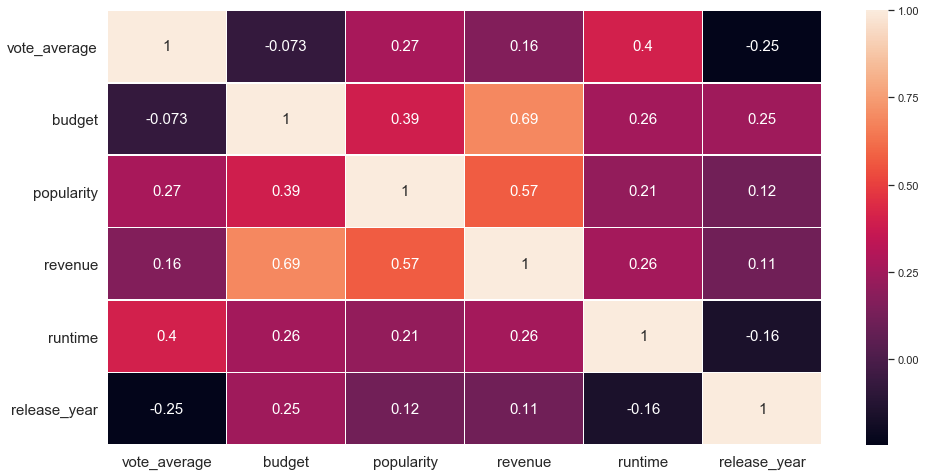

In [69]:
# correlation between numeric features
def plot_corr(df,filename):
    plt.subplots(figsize=(16, 8))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

plot_corr(pred[["vote_average","budget","popularity","revenue","runtime","release_year"]],filename="corr.png")

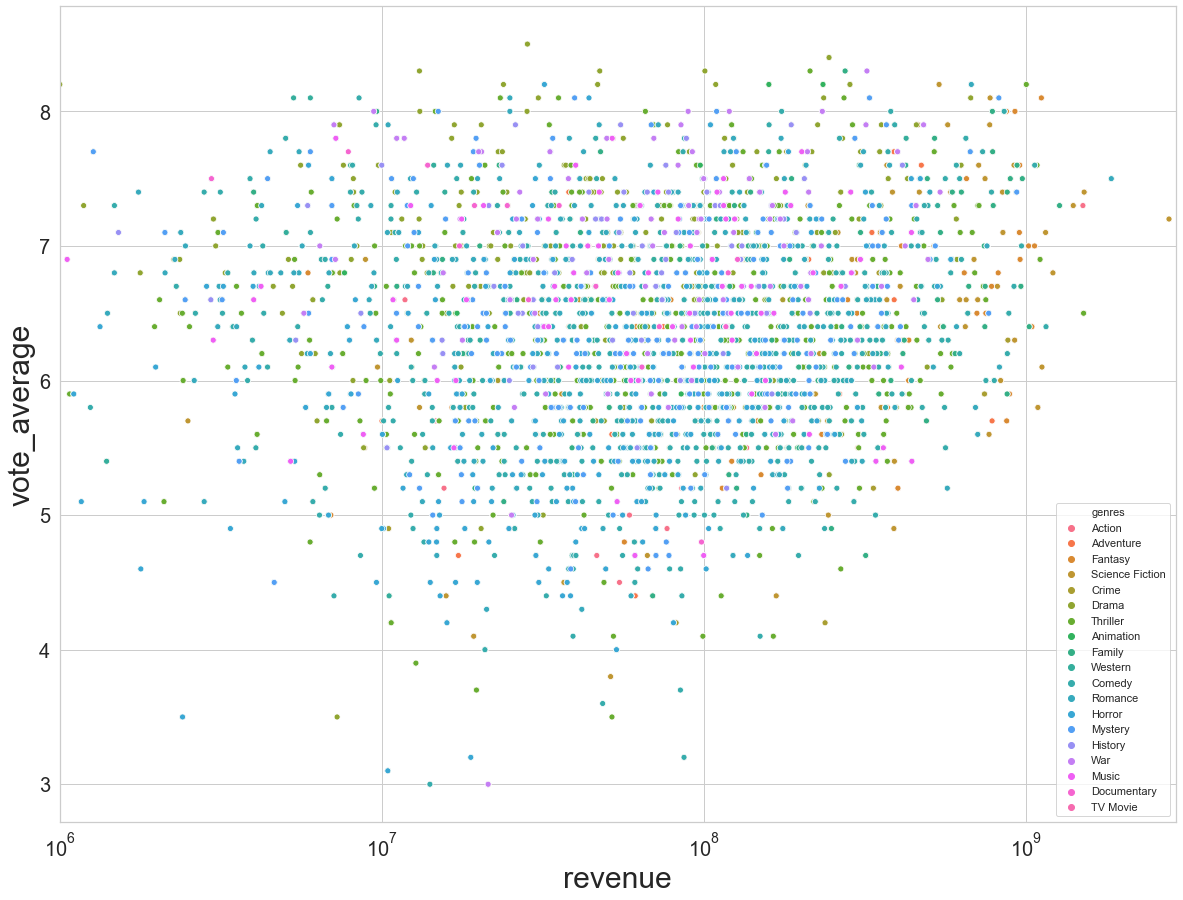

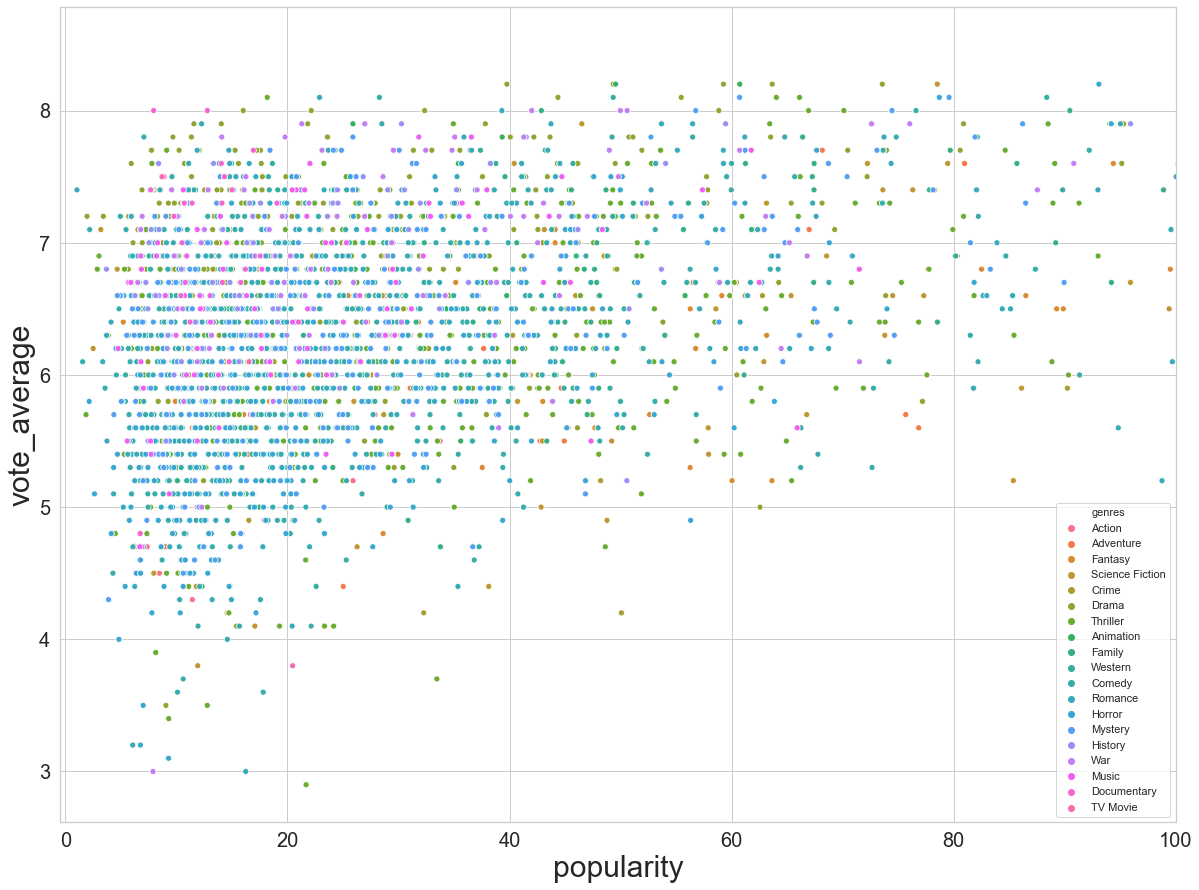

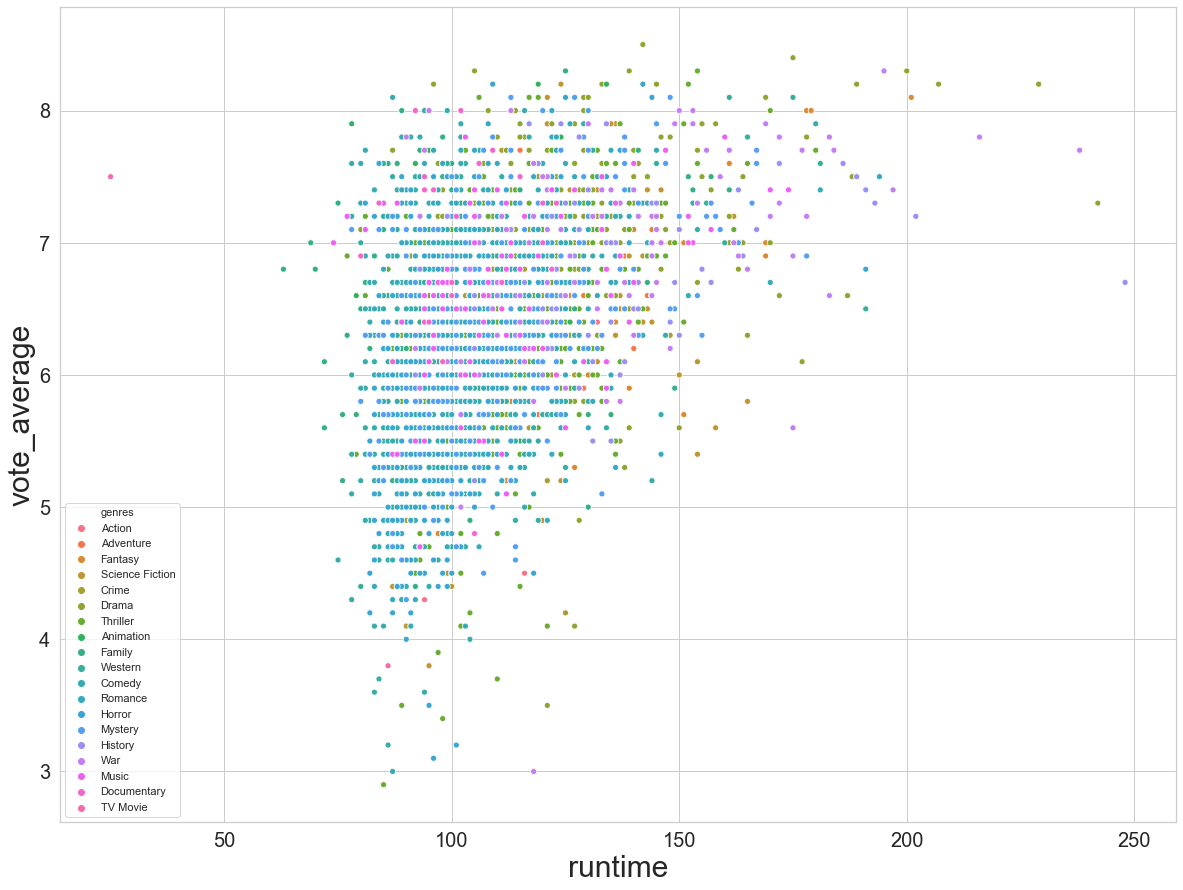

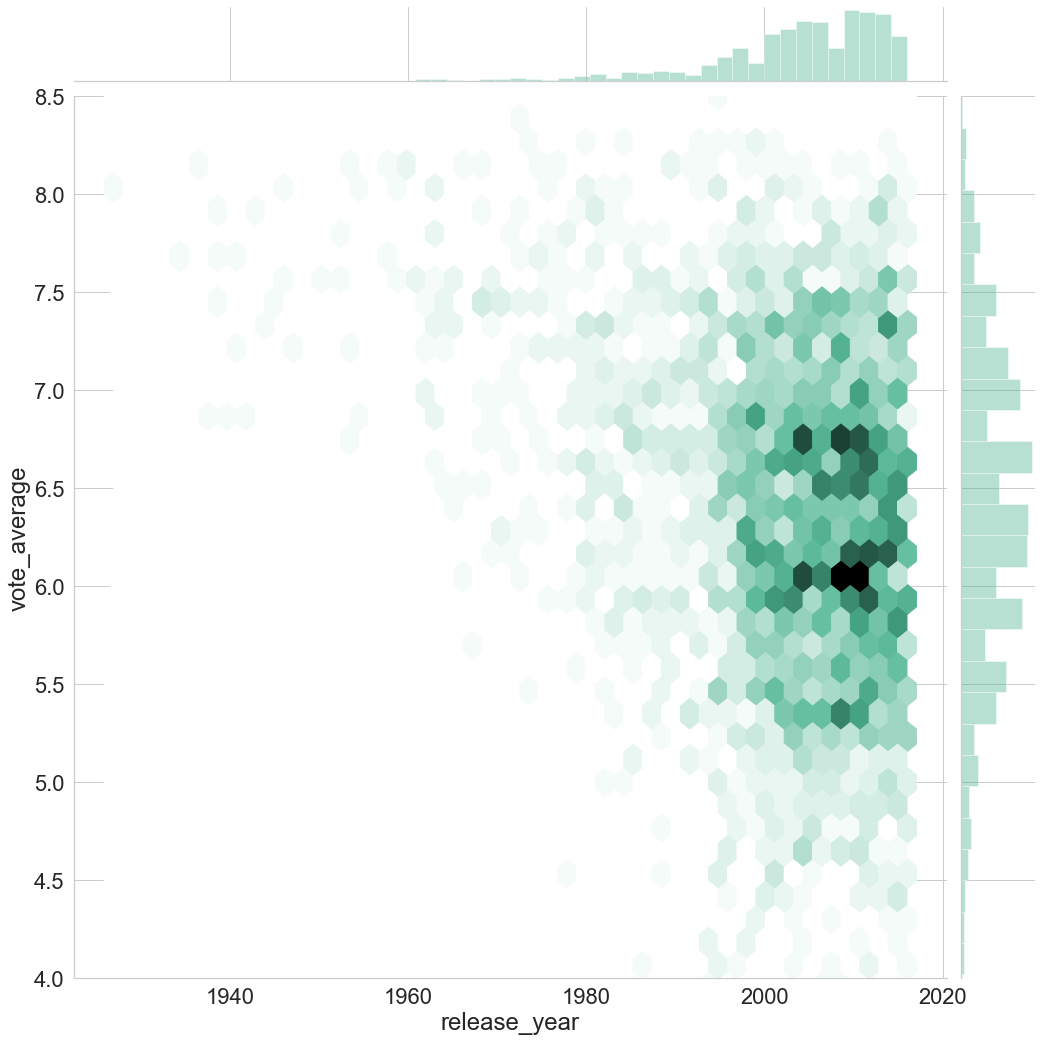

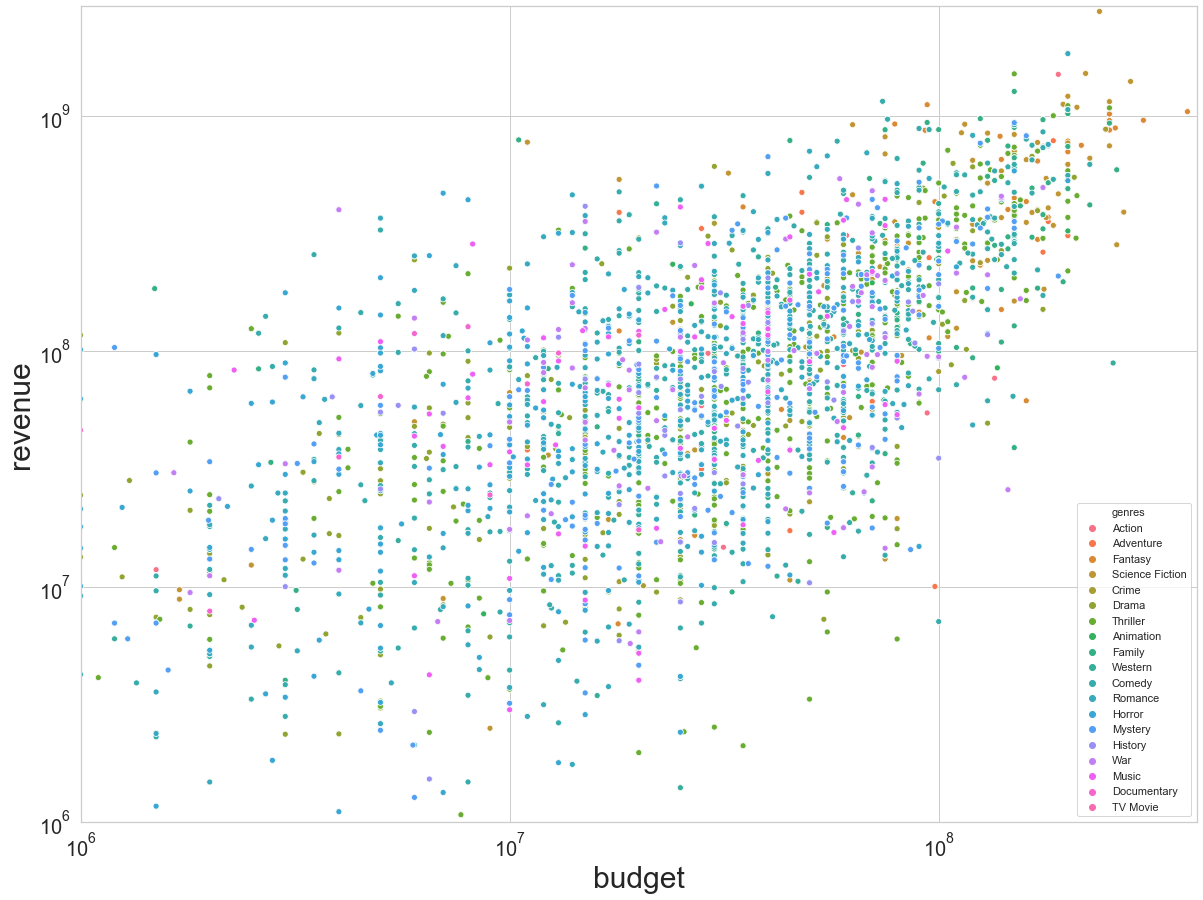

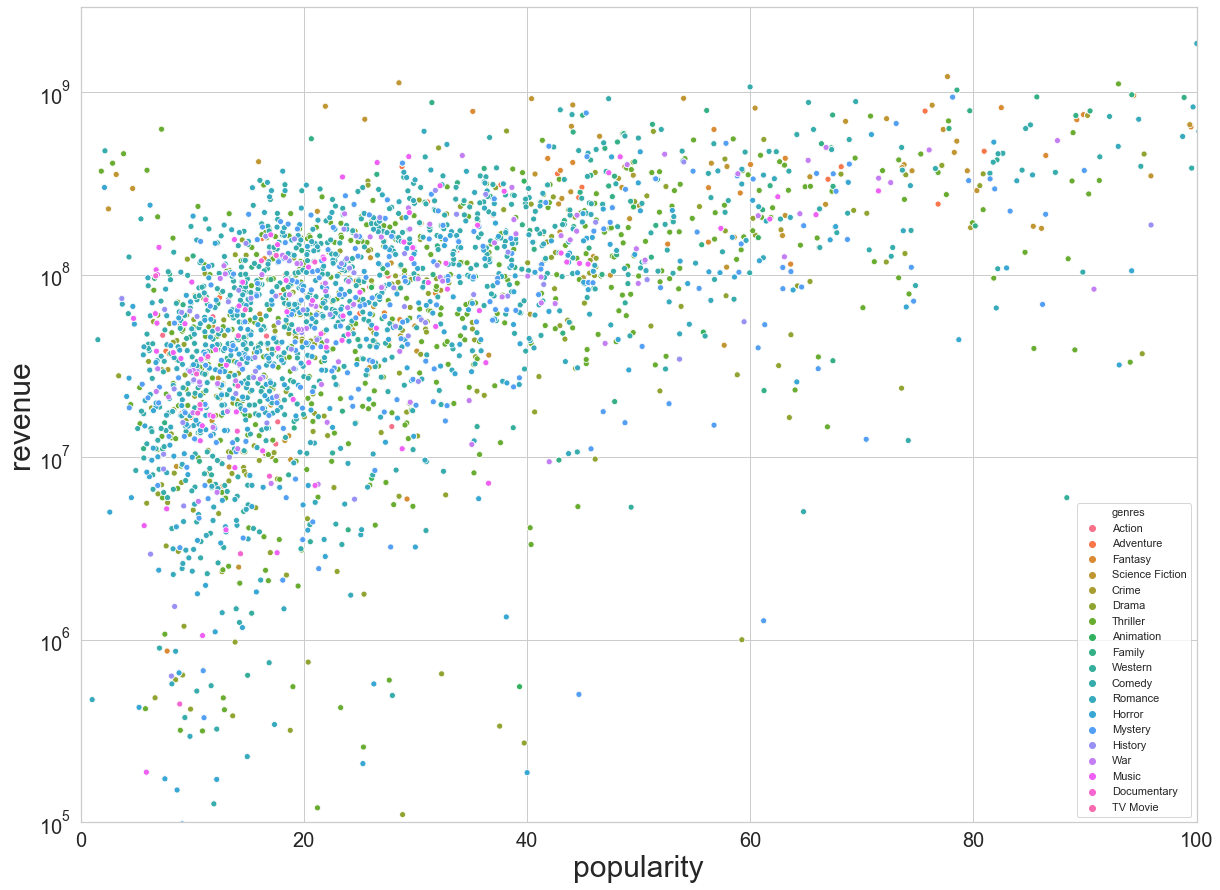

In [73]:
# see the scatter of features
def plotscatter(df,x,y,hue,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 15))
    sns.scatterplot(data=expand_multi_feature(df,hue,"name"),x=x,y=y,hue=hue)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if xlim:plt.xlim(xlim)
    if xscale:plt.xscale(xscale)
    if ylim:plt.ylim(ylim)
    if yscale:plt.yscale(yscale)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

def plotjoint(df,x,y,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style=None,font_scale=2)
    grid=sns.jointplot(pred[x],pred[y],kind="hex",color="#4CB391",height=15,ratio=10,xlim=xlim,ylim=ylim)
    if saving:grid.savefig(filename)
        
    
plotscatter(pred,"revenue","vote_average","genres",xlim=1e6,xscale="log",filename="scatter_revenue_vote.png")
plotscatter(pred,"popularity","vote_average","genres",xlim=(-0.5,100),filename="scatter_popularity_vote.png")
plotscatter(pred,"runtime","vote_average","genres",filename="scatter_runtime_vote.png")
plotjoint(pred,"release_year","vote_average",filename="scatter_year_vote.png",ylim=(4,8.5))

plotscatter(pred,"budget","revenue","genres",xlim=1e6,ylim=1e6,xscale="log",yscale="log",filename="scatter_budget_revenue.png")
plotscatter(pred,"popularity","revenue","genres",xlim=(0,100),ylim=1e5,yscale="log",filename="scatter_popularity_revenue.png")

In [74]:
# selected features
label_name="vote_average"
numeric_features=["budget","runtime","popularity","revenue","release_year"]
multi_hot_features=["genres"]

In [75]:
# define transformers
class MultiHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.categories=[]
    
    def fit(self,X,y=None):
        self.categories=[]
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            self.categories+=list(df.columns)
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=X.index)
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            result=result.join(df)
        for i,cate in enumerate(self.categories):
            if result.columns[i]!=cate:
                result.insert(i,cate,0)
        return result.reset_index(drop=True)

    
def to_split(series,sep="|",index="name",threshold=0):
    count=multi_count(series,index)
    result=pd.Series(index=series.index)
    for i in range(series.size):
        l=eval(series.iloc[i])
        result.iloc[i]=""
        for x in l:
            if count[x[index]]>=threshold:
                result.iloc[i]+=x[index]+sep
    return result

class DataFrameTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,transformers):
        self.transformers=transformers
        
    def fit(self,X,y=None):
        for i in self.transformers:
            if i[1]!="passthrough" and i[1]!="drop":i[1].fit(X[i[2]])
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=range(X.shape[0]))
        for i in self.transformers:
            if i[1]=="passthrough":x=X[i[2]].reset_index(drop=True)
            elif i[1]=="drop":continue
            else:x=i[1].transform(X[i[2]])
            if type(x) is not pd.DataFrame:x=pd.DataFrame(x,columns=i[2])
            result=result.join(x)
        return result

In [77]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
])
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.8,"max_depth":5}
dmat=xgb.DMatrix(preprocessor.fit_transform(pred),pred[label_name])
xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds))).iloc[[-1]]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
746,0.686163,0.009622,0.467422,0.005534,0.46765,0.031394,0.608186,0.011681


In [78]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
    ("multihot",MultiHotEncoder(),multi_hot_features),
])

In [80]:
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.7,"max_depth":7}
dmat=xgb.DMatrix(preprocessor.fit_transform(pred),pred[label_name])
result=xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds)))
result.iloc[[-1]]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
952,0.89921,0.002921,0.264896,0.002991,0.579133,0.018677,0.54089,0.005613


In [82]:
X=preprocessor.fit_transform(pred)
y=pred[label_name]
train_X,valid_X,train_y,valid_y=train_test_split(X,y)
train_mat=xgb.DMatrix(train_X,train_y)
valid_mat=xgb.DMatrix(valid_X,valid_y)
model=xgb.train(xgb_params,train_mat,num_boost_round=result.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


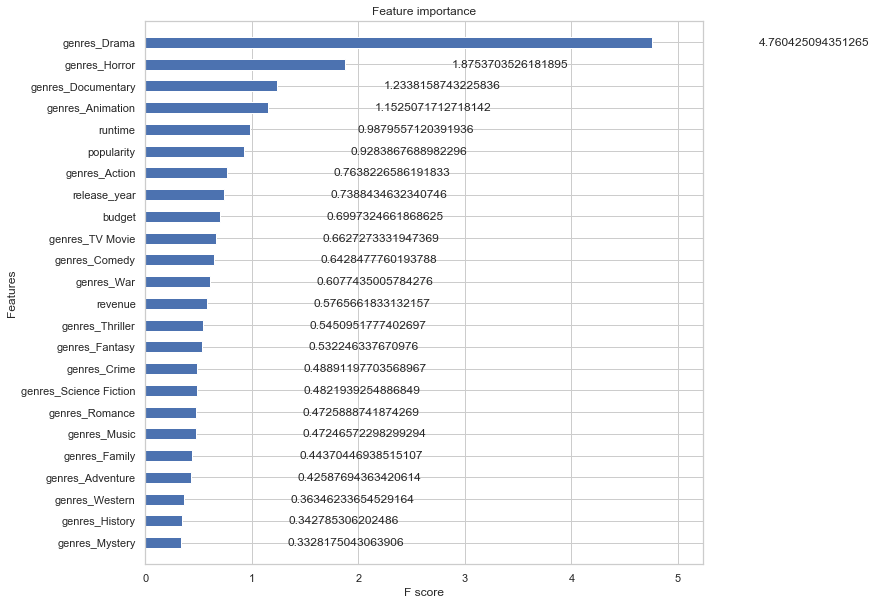

In [84]:
def plot_importance(model,filename,importance_type="weight"):
    f,ax=plt.subplots(figsize=(10,10))
    xgb.plot_importance(model,height=0.5,ax=ax,importance_type=importance_type)
    if saving:plt.savefig(filename,dpi=150,bbox_inches="tight")
    plt.show()
    
plot_importance(model,importance_type="gain",filename="boost_tree_importance.png")